In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns
import csv
from collections import Counter

In [2]:
import warnings
warnings.filterwarnings('ignore')

# Summary

The objective of this notebook is to categorize donors based on the amount of sum that they have donated to Leuven University Fund (LUF) so far. <br>

There are six categories in total and they are categorized as follows:
-  <b>CAT 1</b>: € 0 – 1,249 
-  <b>CAT 2</b>: € 1,250 – 4,999
-  <b>CAT 3</b>: € 5,000 – 14,999
-  <b>CAT 4</b>: € 15,000 – 24,999
-  <b>CAT 5</b>: € 25,000 – 49,999
-  <b>CAT 6</b>: > € 50,000

The main question we are trying to answer in this notebook is, which is more likely to happen: <i>Donors from CAT 1 level taking their donation to CAT 2 level, or donors from CAT 4 level taking their donation to CAT 5 level? </i> <br>

#### Algorithm

- Gifts are arranged based on chronological order (According to ZLUF_DOCDATE: Document Date - the date of the payment)
- Build a matrix of DONORS x GIFTS (#) [No of DONORS x Max count of GIFTS among all donors]
- For each DONOR, consider 6 flags initialized to 0: CAT_1, CAT_2, CAT_3, CAT_4, CAT_5, CAT_6 <br>
- Loop through the matrix, for each DONOR, across all GIFTS:
   -    For each DONOR, sum through donations sequentially
   -    Set the corresponding CAT flag to 1 as soon as the accumulated sum lies within the category range
   -    Eg. If accumulated sum is € 6,000, set CAT_3 flag to 1
- The likelihood of donor moving to category 2 from category 1 is represented by CAT_1_to_2. This is calculated by count of instances where CAT_2 flag is set to 1, given that CAT_1 flag is already set to 1
- Calculate the likelihood for other category shifts 

The example is shown below: <br>
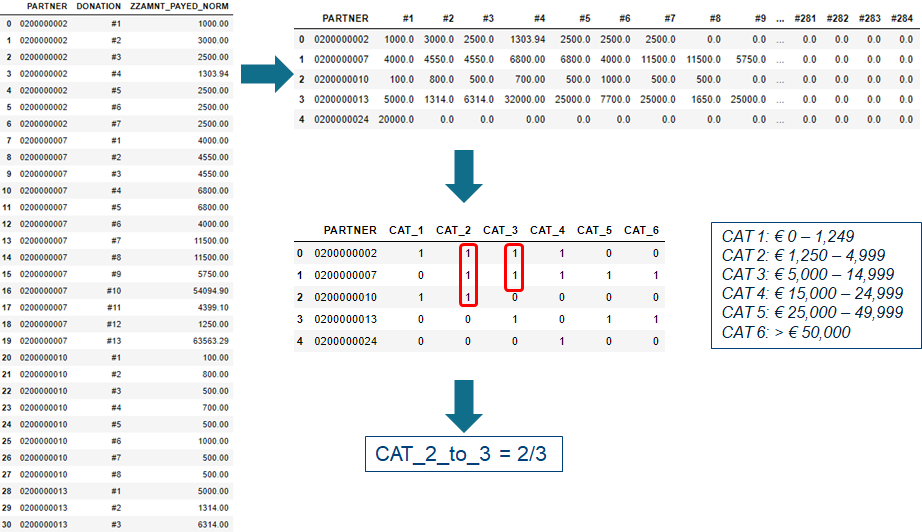

Find the liklihood of all category shifts and answer the question. <br>

The data that is required for this notebook is generated using MySQL and is labeled question7.csv. <br>
The relevant features for this notebook are: <br>
-  <b>PARTNER</b>: Contains the donor id<br>
-  <b>ZZAMNT_PAYED</b>: Contains the donation sum<br>
-  <b>ORDER_GUID</b>: Contains the id of the order line of the donation<br>
-  <b>ZLUF_DOCDATE</b>: Contains the date of donation<br>
<br>

ZZAMNT_PAYED doesn't take into account of joint donation. As in, both Donor A & Donor B donates 1000 Euro for Fund F, the data shows that Donor A donated 1000 Euro for Fund F and donor B donoated 1000 Euro for Fund F. <br>
This needs to be normalized, and that is done using the variable <b>ZZAMNT_PAYED_NORM</b>.

In [3]:
all_gifts = pd.read_csv('sqldata/question7.csv',dtype = str)
df = pd.DataFrame.from_dict(Counter((all_gifts['ORDER_GUID'])), orient='index').reset_index()
df = df.rename(columns={'index':'ORDER_GUID', 0:'ORDER_GUID_COUNT'})
all_gifts = pd.merge(all_gifts,df,on='ORDER_GUID',how='inner')
all_gifts['ZZAMNT_PAYED'] = all_gifts['ZZAMNT_PAYED'].astype('float64')
all_gifts['ORDER_GUID_COUNT'] = all_gifts['ORDER_GUID_COUNT'].astype('int32')
print(all_gifts['ZZAMNT_PAYED'].sum())
all_gifts['ZZAMNT_PAYED_NORM'] = all_gifts['ZZAMNT_PAYED']/all_gifts['ORDER_GUID_COUNT']
print(all_gifts['ZZAMNT_PAYED_NORM'].sum().round(2))
print(all_gifts.shape)
all_gifts.head()

138438337.52
130563906.13
(130934, 20)


,PARTNER,ZZGEBOORTEJAAR,TYPE,BIRTHPL,BU_LANGU,NATIO,POST_CODE1,COUNTRY,TITLE_ACADEMDIC,TITLE,ORDER_GUID,ZZAMNT_PAYED,CREATED_AT,POSTING_DATE,ZLUF_DOCDATE,ZLUF_DANKBRF,CREDIT_CATEGORY,CREDIT_DESCRIPTION,ORDER_GUID_COUNT,ZZAMNT_PAYED_NORM
0,0200000002,0,2,NaN,NaN,NaN,3000,BE,NaN,NaN,2294EB49A90B1ED5B8CC04B381270A59,1000.00,2016-03-05 00:23:48,2016-03-05 00:00:00,2004-07-20 00:00:00,2004-01-01 00:00:00,00003,dienst Alumni,1,1000.00
1,0200000002,0,2,NaN,NaN,NaN,3000,BE,NaN,NaN,2294EB49A90B1ED5B8D00EBDD2554A59,2500.00,2016-03-05 04:15:06,2016-03-05 00:00:00,2014-07-01 00:00:00,2014-09-24 00:00:00,00003,Faculteit Rechtsgeleerdheid,1,2500.00
2,0200000002,0,2,NaN,NaN,NaN,3000,BE,NaN,NaN,2294EB49A90B1ED5B8CCE0FDE3458A59,3000.00,2016-03-05 01:13:04,2016-03-05 00:00:00,2007-10-05 00:00:00,2008-04-08 00:00:00,00003,dienst Alumni,1,3000.00
3,0200000002,0,2,NaN,NaN,NaN,3000,BE,NaN,NaN,2294EB49A90B1ED5B8D00EC6A72B0A59,1303.94,2016-03-05 04:15:07,2016-03-05 00:00:00,2014-07-01 00:00:00,2014-09-24 00:00:00,00003,Faculteit Rechtsgeleerdheid,1,1303.94
4,0200000002,0,2,NaN,NaN,NaN,3000,BE,NaN,NaN,2294EB49A90B1ED5B8D00EC23775CA59,2500.00,2016-03-05 04:15:07,2016-03-05 00:00:00,2014-07-01 00:00:00,2014-09-24 00:00:00,00003,Faculteit Rechtsgeleerdheid,1,2500.00


In [4]:
#Check for inconsistency among the data. One inconsistency could be if the donation sum is less than 0
all_gifts['ZZAMNT_PAYED_NORM'] = all_gifts['ZZAMNT_PAYED_NORM'].astype('float64')
all_gifts[all_gifts['ZZAMNT_PAYED_NORM'] < 0]

,PARTNER,ZZGEBOORTEJAAR,TYPE,BIRTHPL,BU_LANGU,NATIO,POST_CODE1,COUNTRY,TITLE_ACADEMDIC,TITLE,ORDER_GUID,ZZAMNT_PAYED,CREATED_AT,POSTING_DATE,ZLUF_DOCDATE,ZLUF_DANKBRF,CREDIT_CATEGORY,CREDIT_DESCRIPTION,ORDER_GUID_COUNT,ZZAMNT_PAYED_NORM
126029,0201222693,0,1,NaN,N,NaN,8200,BE,NaN,0002,2294EB49A90D1ED7A78F46F0734B400F,-675.0,2017-09-18 16:03:59,2017-09-18 00:00:00,2017-08-10 00:00:00,NaN,00001,Fonds Digestieve Oncologie,2,-337.5
126030,0201222694,0,1,NaN,NaN,NaN,8200,BE,NaN,0001,2294EB49A90D1ED7A78F46F0734B400F,-675.0,2017-09-18 16:03:59,2017-09-18 00:00:00,2017-08-10 00:00:00,NaN,00001,Fonds Digestieve Oncologie,2,-337.5


In [5]:
all_gifts[all_gifts['PARTNER']=='0201222693']

,PARTNER,ZZGEBOORTEJAAR,TYPE,BIRTHPL,BU_LANGU,NATIO,POST_CODE1,COUNTRY,TITLE_ACADEMDIC,TITLE,ORDER_GUID,ZZAMNT_PAYED,CREATED_AT,POSTING_DATE,ZLUF_DOCDATE,ZLUF_DANKBRF,CREDIT_CATEGORY,CREDIT_DESCRIPTION,ORDER_GUID_COUNT,ZZAMNT_PAYED_NORM
126027,0201222693,0,1,NaN,N,NaN,8200,BE,NaN,0002,2294EB49A90D1ED7A78F42ADFA0B402D,750.0,2017-09-18 16:03:02,2017-09-18 00:00:00,2017-08-08 00:00:00,2017-10-16 00:00:00,00001,Fonds Digestieve Oncologie,2,375.0
126029,0201222693,0,1,NaN,N,NaN,8200,BE,NaN,0002,2294EB49A90D1ED7A78F46F0734B400F,-675.0,2017-09-18 16:03:59,2017-09-18 00:00:00,2017-08-10 00:00:00,NaN,00001,Fonds Digestieve Oncologie,2,-337.5


In [6]:
all_gifts[all_gifts['PARTNER']=='0201222694']

,PARTNER,ZZGEBOORTEJAAR,TYPE,BIRTHPL,BU_LANGU,NATIO,POST_CODE1,COUNTRY,TITLE_ACADEMDIC,TITLE,ORDER_GUID,ZZAMNT_PAYED,CREATED_AT,POSTING_DATE,ZLUF_DOCDATE,ZLUF_DANKBRF,CREDIT_CATEGORY,CREDIT_DESCRIPTION,ORDER_GUID_COUNT,ZZAMNT_PAYED_NORM
126028,0201222694,0,1,NaN,NaN,NaN,8200,BE,NaN,0001,2294EB49A90D1ED7A78F42ADFA0B402D,750.0,2017-09-18 16:03:02,2017-09-18 00:00:00,2017-08-08 00:00:00,2017-10-16 00:00:00,00001,Fonds Digestieve Oncologie,2,375.0
126030,0201222694,0,1,NaN,NaN,NaN,8200,BE,NaN,0001,2294EB49A90D1ED7A78F46F0734B400F,-675.0,2017-09-18 16:03:59,2017-09-18 00:00:00,2017-08-10 00:00:00,NaN,00001,Fonds Digestieve Oncologie,2,-337.5


In [7]:
#Drop these two rows
all_gifts = all_gifts[all_gifts['ZZAMNT_PAYED_NORM'] >= 0]
all_gifts.reset_index(drop=True,inplace=True)
print(len(set(all_gifts['PARTNER']))) #Number of donors
print(all_gifts['ZZAMNT_PAYED_NORM'].sum().round(2))
print(all_gifts.shape)
all_gifts.head()

56897
130564581.13
(130932, 20)


,PARTNER,ZZGEBOORTEJAAR,TYPE,BIRTHPL,BU_LANGU,NATIO,POST_CODE1,COUNTRY,TITLE_ACADEMDIC,TITLE,ORDER_GUID,ZZAMNT_PAYED,CREATED_AT,POSTING_DATE,ZLUF_DOCDATE,ZLUF_DANKBRF,CREDIT_CATEGORY,CREDIT_DESCRIPTION,ORDER_GUID_COUNT,ZZAMNT_PAYED_NORM
0,0200000002,0,2,NaN,NaN,NaN,3000,BE,NaN,NaN,2294EB49A90B1ED5B8CC04B381270A59,1000.00,2016-03-05 00:23:48,2016-03-05 00:00:00,2004-07-20 00:00:00,2004-01-01 00:00:00,00003,dienst Alumni,1,1000.00
1,0200000002,0,2,NaN,NaN,NaN,3000,BE,NaN,NaN,2294EB49A90B1ED5B8D00EBDD2554A59,2500.00,2016-03-05 04:15:06,2016-03-05 00:00:00,2014-07-01 00:00:00,2014-09-24 00:00:00,00003,Faculteit Rechtsgeleerdheid,1,2500.00
2,0200000002,0,2,NaN,NaN,NaN,3000,BE,NaN,NaN,2294EB49A90B1ED5B8CCE0FDE3458A59,3000.00,2016-03-05 01:13:04,2016-03-05 00:00:00,2007-10-05 00:00:00,2008-04-08 00:00:00,00003,dienst Alumni,1,3000.00
3,0200000002,0,2,NaN,NaN,NaN,3000,BE,NaN,NaN,2294EB49A90B1ED5B8D00EC6A72B0A59,1303.94,2016-03-05 04:15:07,2016-03-05 00:00:00,2014-07-01 00:00:00,2014-09-24 00:00:00,00003,Faculteit Rechtsgeleerdheid,1,1303.94
4,0200000002,0,2,NaN,NaN,NaN,3000,BE,NaN,NaN,2294EB49A90B1ED5B8D00EC23775CA59,2500.00,2016-03-05 04:15:07,2016-03-05 00:00:00,2014-07-01 00:00:00,2014-09-24 00:00:00,00003,Faculteit Rechtsgeleerdheid,1,2500.00


The LUF has had 56,897 donors since 2002 and they have made total donation of 130,564,581.13 Euro.

In [8]:
required_cols = ['PARTNER', 'CREDIT_CATEGORY', 'ZZAMNT_PAYED_NORM', 'ZLUF_DOCDATE']
required_data = all_gifts[required_cols]
print(required_data.shape)
required_data.head()

(130932, 4)


,PARTNER,CREDIT_CATEGORY,ZZAMNT_PAYED_NORM,ZLUF_DOCDATE
0,0200000002,00003,1000.00,2004-07-20 00:00:00
1,0200000002,00003,2500.00,2014-07-01 00:00:00
2,0200000002,00003,3000.00,2007-10-05 00:00:00
3,0200000002,00003,1303.94,2014-07-01 00:00:00
4,0200000002,00003,2500.00,2014-07-01 00:00:00


Sort the donation data for each partner according to the date of donation (ZLUF_DOCDATE)

In [9]:
required_data = required_data.sort_values(['PARTNER', 'ZLUF_DOCDATE'], ascending=[1, 1])
required_data.reset_index(drop=True, inplace=True)
print(required_data.shape)
required_data.head()

(130932, 4)


,PARTNER,CREDIT_CATEGORY,ZZAMNT_PAYED_NORM,ZLUF_DOCDATE
0,0200000002,00003,1000.00,2004-07-20 00:00:00
1,0200000002,00003,3000.00,2007-10-05 00:00:00
2,0200000002,00003,2500.00,2014-07-01 00:00:00
3,0200000002,00003,1303.94,2014-07-01 00:00:00
4,0200000002,00003,2500.00,2014-07-01 00:00:00


In [10]:
required_data['PARTNER'].value_counts()[:5]

0201087670    284
0201103039    242
0200005845    198
0201088307    198
0201064765    198
Name: PARTNER, dtype: int64

There is donor with PARTNER ID = '0201087670' who has donated 284 times in total to the LUF. <br>
If we were to create a DONORS x GIFT(#) matrix then this matrix would be of dimensions 56937 x 284. <br>
As one can imagine, this would be a pretty sparse matrix as most donors donate only once to LUF.

In [11]:
required_data['DONATION'] = required_data.groupby(['PARTNER']).cumcount()+1
required_data = required_data[['PARTNER','DONATION','ZZAMNT_PAYED_NORM']]
required_data['DONATION'] = '#'+required_data.DONATION.map(str)
print(required_data.shape)
required_data.head()

(130932, 3)


,PARTNER,DONATION,ZZAMNT_PAYED_NORM
0,0200000002,#1,1000.00
1,0200000002,#2,3000.00
2,0200000002,#3,2500.00
3,0200000002,#4,1303.94
4,0200000002,#5,2500.00


In the below cell, DONOR x GIFT (#) matrix is computed.

In [12]:
required_matrix = pd.crosstab(index=required_data.iloc[:,0], columns=required_data.iloc[:,1], 
                  values=required_data.iloc[:,2],aggfunc='sum')
required_matrix['PARTNER'] = required_matrix.index
required_matrix.reset_index(drop=True, inplace=True)
num_don = len(required_matrix.columns)-1
matrix_cols = ['PARTNER'] +  ['#'+str(x+1) for x in range(num_don)]
required_matrix = required_matrix[matrix_cols]
required_matrix = required_matrix.fillna(0)
print(required_matrix.shape)
required_matrix.head()

(56897, 285)


DONATION,PARTNER,#1,#2,#3,#4,#5,#6,#7,#8,#9,...,#275,#276,#277,#278,#279,#280,#281,#282,#283,#284
0,0200000002,1000.0,3000.0,2500.0,1303.94,2500.0,2500.0,2500.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0200000007,4000.0,4550.0,4550.0,6800.00,6800.0,4000.0,11500.0,11500.0,5750.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0200000010,100.0,800.0,500.0,700.00,500.0,1000.0,500.0,500.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0200000013,5000.0,1314.0,6314.0,32000.00,25000.0,7700.0,25000.0,1650.0,25000.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0200000024,20000.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [13]:
#Create the flag matrices and set it to zero
num_partners = len(required_matrix['PARTNER'])
flags= pd.DataFrame(
{
"CAT_1" : [0 for x in range(num_partners)],
"CAT_2" : [0 for x in range(num_partners)],
"CAT_3" : [0 for x in range(num_partners)],
"CAT_4" : [0 for x in range(num_partners)],
"CAT_5" : [0 for x in range(num_partners)],
"CAT_6" : [0 for x in range(num_partners)],
},
index = required_matrix.index)
print(flags.shape)
flags.head()

(56897, 6)


,CAT_1,CAT_2,CAT_3,CAT_4,CAT_5,CAT_6
0,0,0,0,0,0,0
1,0,0,0,0,0,0
2,0,0,0,0,0,0
3,0,0,0,0,0,0
4,0,0,0,0,0,0


In [14]:
#Concatenate the two matrices
required_matrix = pd.concat([required_matrix,flags],axis=1)
print(required_matrix.shape)
required_matrix.head()

(56897, 291)


,PARTNER,#1,#2,#3,#4,#5,#6,#7,#8,#9,...,#281,#282,#283,#284,CAT_1,CAT_2,CAT_3,CAT_4,CAT_5,CAT_6
0,0200000002,1000.0,3000.0,2500.0,1303.94,2500.0,2500.0,2500.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0,0,0,0,0,0
1,0200000007,4000.0,4550.0,4550.0,6800.00,6800.0,4000.0,11500.0,11500.0,5750.0,...,0.0,0.0,0.0,0.0,0,0,0,0,0,0
2,0200000010,100.0,800.0,500.0,700.00,500.0,1000.0,500.0,500.0,0.0,...,0.0,0.0,0.0,0.0,0,0,0,0,0,0
3,0200000013,5000.0,1314.0,6314.0,32000.00,25000.0,7700.0,25000.0,1650.0,25000.0,...,0.0,0.0,0.0,0.0,0,0,0,0,0,0
4,0200000024,20000.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0,0,0,0,0,0


Compute the Categories that each donor had been in during the donor's lifecycle by setting the corresponding CAT flag according to the accumulated donation sum to the LUF.

In [15]:
don_cols = ['#'+str(x+1) for x in range(num_don)]
for index, row in required_matrix.iterrows():
    sum_row = 0
    for col in don_cols:
        sum_row = sum_row + row[col]
        if(sum_row >= 0.00 and sum_row <= 1249.00):
            #row['CAT_1'] == 1
            required_matrix.at[index,'CAT_1'] = 1
        if(sum_row >= 1250.00 and sum_row <= 4999.00):
            required_matrix.at[index,'CAT_2'] = 1
        if(sum_row >= 5000.00 and sum_row <= 14999.00):
            required_matrix.at[index,'CAT_3'] = 1
        if(sum_row >= 15000.00 and sum_row <= 24999.00):
            required_matrix.at[index,'CAT_4'] = 1
        if(sum_row >= 25000.00 and sum_row <= 49999.00):
            required_matrix.at[index,'CAT_5'] = 1
        if(sum_row >= 50000.00):
            required_matrix.at[index,'CAT_6'] = 1
        
required_matrix.head()

,PARTNER,#1,#2,#3,#4,#5,#6,#7,#8,#9,...,#281,#282,#283,#284,CAT_1,CAT_2,CAT_3,CAT_4,CAT_5,CAT_6
0,0200000002,1000.0,3000.0,2500.0,1303.94,2500.0,2500.0,2500.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1,1,1,1,0,0
1,0200000007,4000.0,4550.0,4550.0,6800.00,6800.0,4000.0,11500.0,11500.0,5750.0,...,0.0,0.0,0.0,0.0,0,1,1,1,1,1
2,0200000010,100.0,800.0,500.0,700.00,500.0,1000.0,500.0,500.0,0.0,...,0.0,0.0,0.0,0.0,1,1,0,0,0,0
3,0200000013,5000.0,1314.0,6314.0,32000.00,25000.0,7700.0,25000.0,1650.0,25000.0,...,0.0,0.0,0.0,0.0,0,0,1,0,1,1
4,0200000024,20000.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0,0,0,1,0,0


#### Category Shifts (CAT_i to CAT_i+1)

In [16]:
#CAT_1_to_2, CAT_2_to_3, CAT_3_to_4, CAT_4_to_5, CAT_5_to_6
CAT_1_to_2 = (required_matrix['CAT_2'][required_matrix['CAT_1']==1].sum())/(required_matrix['CAT_1'][required_matrix['CAT_1']==1].sum())
CAT_2_to_3 = (required_matrix['CAT_3'][required_matrix['CAT_2']==1].sum())/(required_matrix['CAT_2'][required_matrix['CAT_2']==1].sum())
CAT_3_to_4 = (required_matrix['CAT_4'][required_matrix['CAT_3']==1].sum())/(required_matrix['CAT_3'][required_matrix['CAT_3']==1].sum())
CAT_4_to_5 = (required_matrix['CAT_5'][required_matrix['CAT_4']==1].sum())/(required_matrix['CAT_4'][required_matrix['CAT_4']==1].sum())
CAT_5_to_6 = (required_matrix['CAT_6'][required_matrix['CAT_5']==1].sum())/(required_matrix['CAT_5'][required_matrix['CAT_5']==1].sum())

cat_shift_cols = ['CAT_SHIFT','RAISED_CASES','TOTAL_NUMBER_OF_CASES','CAT_SHIFT_LIKELIHOOD']
cat_shift_df = pd.DataFrame(columns=cat_shift_cols)
cat_shift_df = cat_shift_df.append(pd.DataFrame([['CAT_1_to_2',required_matrix['CAT_2'][required_matrix['CAT_1']==1].sum(),
                                                  required_matrix['CAT_1'][required_matrix['CAT_1']==1].sum(),
                                                  round(CAT_1_to_2,5)]],columns=cat_shift_cols))
cat_shift_df = cat_shift_df.append(pd.DataFrame([['CAT_2_to_3',required_matrix['CAT_3'][required_matrix['CAT_2']==1].sum(),
                                                  required_matrix['CAT_2'][required_matrix['CAT_2']==1].sum(),
                                                  round(CAT_2_to_3,5)]],columns=cat_shift_cols))
cat_shift_df = cat_shift_df.append(pd.DataFrame([['CAT_3_to_4',required_matrix['CAT_4'][required_matrix['CAT_3']==1].sum(),
                                                  required_matrix['CAT_3'][required_matrix['CAT_3']==1].sum(),
                                                  round(CAT_3_to_4,5)]],columns=cat_shift_cols))
cat_shift_df = cat_shift_df.append(pd.DataFrame([['CAT_4_to_5',required_matrix['CAT_5'][required_matrix['CAT_4']==1].sum(),
                                                  required_matrix['CAT_4'][required_matrix['CAT_4']==1].sum(),
                                                  round(CAT_4_to_5,5)]],columns=cat_shift_cols))
cat_shift_df = cat_shift_df.append(pd.DataFrame([['CAT_5_to_6',required_matrix['CAT_6'][required_matrix['CAT_5']==1].sum(),
                                                  required_matrix['CAT_5'][required_matrix['CAT_5']==1].sum(),
                                                  round(CAT_5_to_6,5)]],columns=cat_shift_cols))
cat_shift_df.reset_index(drop=True,inplace=True)
cat_shift_df

,CAT_SHIFT,RAISED_CASES,TOTAL_NUMBER_OF_CASES,CAT_SHIFT_LIKELIHOOD
0,CAT_1_to_2,1080,55191,0.01957
1,CAT_2_to_3,369,2018,0.18285
2,CAT_3_to_4,236,925,0.25514
3,CAT_4_to_5,167,356,0.46910
4,CAT_5_to_6,170,329,0.51672


<b>From the above dataframe it can be seen that the likelihood of a donor moving from CAT 4 to CAT 5 is much higher than the likelihood of a donor moving from CAT 1 to CAT 2. </b>

#### Category Jumps (CAT_i to CAT_i+n, n>1)

Here we calculate category jumps. <br>
As in for example: CAT_1_to_6  -  Means that a donor from Category 1 directly jumps to Category 6, bypassing Categories 2,3,4, & 5. (After a donation so that accumulated sum is now in Category 6)

In [17]:
#From Cat 1 to 3,4,5,6
count_1 = required_matrix['CAT_1'][required_matrix['CAT_1']==1].sum()
count_6_given_only_1 = required_matrix['CAT_6'][(required_matrix['CAT_1']==1) & (required_matrix['CAT_2']==0) & 
                                                (required_matrix['CAT_3']==0) & (required_matrix['CAT_4']==0) & 
                                                (required_matrix['CAT_5']==0)].sum()
count_5_given_only_1 = required_matrix['CAT_5'][(required_matrix['CAT_1']==1) & (required_matrix['CAT_2']==0) & 
                                                (required_matrix['CAT_3']==0) & (required_matrix['CAT_4']==0)].sum()
count_4_given_only_1 = required_matrix['CAT_4'][(required_matrix['CAT_1']==1) & (required_matrix['CAT_2']==0) & 
                                                (required_matrix['CAT_3']==0)].sum()
count_3_given_only_1 = required_matrix['CAT_3'][(required_matrix['CAT_1']==1) & (required_matrix['CAT_2']==0)].sum()
CAT_1_to_6 = count_6_given_only_1/count_1
CAT_1_to_5 = count_5_given_only_1/count_1
CAT_1_to_4 = count_4_given_only_1/count_1
CAT_1_to_3 = count_3_given_only_1/count_1

cat_jump_cols = ['CAT_JUMP','RAISED_CASES','TOTAL_NUMBER_OF_CASES','CAT_JUMP_LIKELIHOOD']
cat_jump_df = pd.DataFrame(columns=cat_jump_cols)
cat_jump_df = cat_jump_df.append(pd.DataFrame([['CAT_1_to_6',count_6_given_only_1,count_1,round(CAT_1_to_6,5)]],
                                             columns=cat_jump_cols))
cat_jump_df = cat_jump_df.append(pd.DataFrame([['CAT_1_to_5',count_5_given_only_1,count_1,round(CAT_1_to_5,5)]],
                                             columns=cat_jump_cols))
cat_jump_df = cat_jump_df.append(pd.DataFrame([['CAT_1_to_4',count_4_given_only_1,count_1,round(CAT_1_to_4,5)]],
                                             columns=cat_jump_cols))
cat_jump_df = cat_jump_df.append(pd.DataFrame([['CAT_1_to_3',count_3_given_only_1,count_1,round(CAT_1_to_3,5)]],
                                             columns=cat_jump_cols))


#From Cat 2 to 4,5,6
count_2 = required_matrix['CAT_2'][required_matrix['CAT_2']==1].sum()
count_6_given_only_2 = required_matrix['CAT_6'][(required_matrix['CAT_2']==1) & (required_matrix['CAT_3']==0) & 
                                                (required_matrix['CAT_4']==0) & (required_matrix['CAT_5']==0)].sum()
count_5_given_only_2 = required_matrix['CAT_5'][(required_matrix['CAT_2']==1) & (required_matrix['CAT_3']==0) & 
                                                (required_matrix['CAT_4']==0)].sum()
count_4_given_only_2 = required_matrix['CAT_4'][(required_matrix['CAT_2']==1) & (required_matrix['CAT_3']==0)].sum()
CAT_2_to_6 = count_6_given_only_2/count_2
CAT_2_to_5 = count_5_given_only_2/count_2
CAT_2_to_4 = count_4_given_only_2/count_2

cat_jump_df = cat_jump_df.append(pd.DataFrame([['CAT_2_to_6',count_6_given_only_2,count_2,round(CAT_2_to_6,5)]],
                                             columns=cat_jump_cols))
cat_jump_df = cat_jump_df.append(pd.DataFrame([['CAT_2_to_5',count_5_given_only_2,count_2,round(CAT_2_to_5,5)]],
                                             columns=cat_jump_cols))
cat_jump_df = cat_jump_df.append(pd.DataFrame([['CAT_2_to_4',count_4_given_only_2,count_2,round(CAT_2_to_4,5)]],
                                             columns=cat_jump_cols))


#From Cat 3 to 5,6
count_3 = required_matrix['CAT_3'][required_matrix['CAT_3']==1].sum()
count_6_given_only_3 = required_matrix['CAT_6'][(required_matrix['CAT_3']==1) & (required_matrix['CAT_4']==0) & 
                                                (required_matrix['CAT_5']==0)].sum()
count_5_given_only_3 = required_matrix['CAT_5'][(required_matrix['CAT_3']==1) & (required_matrix['CAT_4']==0)].sum()
CAT_3_to_6 = count_6_given_only_3/count_3
CAT_3_to_5 = count_5_given_only_3/count_3

cat_jump_df = cat_jump_df.append(pd.DataFrame([['CAT_3_to_6',count_6_given_only_3,count_3,round(CAT_3_to_6,5)]],
                                             columns=cat_jump_cols))
cat_jump_df = cat_jump_df.append(pd.DataFrame([['CAT_3_to_5',count_5_given_only_3,count_3,round(CAT_3_to_5,5)]],
                                             columns=cat_jump_cols))


#From Cat 4 to 6
count_4 = required_matrix['CAT_4'][required_matrix['CAT_4']==1].sum()
count_6_given_only_4 = required_matrix['CAT_6'][(required_matrix['CAT_4']==1) & (required_matrix['CAT_5']==0)].sum()
CAT_4_to_6 = count_6_given_only_4/count_4

cat_jump_df = cat_jump_df.append(pd.DataFrame([['CAT_4_to_6',count_6_given_only_4,count_4,round(CAT_4_to_6,5)]],
                                             columns=cat_jump_cols))
cat_jump_df.reset_index(drop=True,inplace=True)
cat_jump_df

,CAT_JUMP,RAISED_CASES,TOTAL_NUMBER_OF_CASES,CAT_JUMP_LIKELIHOOD
0,CAT_1_to_6,25,55191,0.00045
1,CAT_1_to_5,14,55191,0.00025
2,CAT_1_to_4,17,55191,0.00031
3,CAT_1_to_3,88,55191,0.00159
4,CAT_2_to_6,7,2018,0.00347
5,CAT_2_to_5,7,2018,0.00347
6,CAT_2_to_4,14,2018,0.00694
7,CAT_3_to_6,25,925,0.02703
8,CAT_3_to_5,39,925,0.04216
9,CAT_4_to_6,11,356,0.03090


Category jumps are very uncommon.

In [18]:
Cat_1_to_6_jumpers = pd.DataFrame(required_matrix['PARTNER'][(required_matrix['CAT_1']==1) & (required_matrix['CAT_2']==0) & 
                                                             (required_matrix['CAT_3']==0) & (required_matrix['CAT_4']==0) &
                                                             (required_matrix['CAT_5']==0) & (required_matrix['CAT_6']==1)])
Cat_1_to_6_jumpers.reset_index(drop=True,inplace=True)
Cat_1_to_6_jumpers_donations = pd.merge(Cat_1_to_6_jumpers,all_gifts,on='PARTNER',how='inner')
Cat_1_to_6_jumpers_donations = Cat_1_to_6_jumpers_donations.drop(['ORDER_GUID','CREATED_AT','POSTING_DATE','ZZGEBOORTEJAAR',
                                                                  'BIRTHPL','BU_LANGU','NATIO','COUNTRY','POST_CODE1',
                                                                  'TITLE_ACADEMDIC','TITLE','ZZAMNT_PAYED'],axis=1)
Cat_1_to_6_jumpers_donations = Cat_1_to_6_jumpers_donations.sort_values(['PARTNER','ZLUF_DOCDATE'])
Cat_1_to_6_jumpers_donations.reset_index(drop=True,inplace=True)
Cat_1_to_6_jumpers_donations

,PARTNER,TYPE,ZLUF_DOCDATE,ZLUF_DANKBRF,CREDIT_CATEGORY,CREDIT_DESCRIPTION,ORDER_GUID_COUNT,ZZAMNT_PAYED_NORM
0,0200008192,1,2004-12-07 00:00:00,2006-01-01 00:00:00,00001,Fonds Roger Dillemans,1,31.00
1,0200008192,1,2008-09-15 00:00:00,2009-03-27 00:00:00,00003,diverse doelen aan de KU Leuven,1,50.00
2,0200008192,1,2011-04-08 00:00:00,2011-07-12 00:00:00,00001,Fonds Roger Dillemans,1,50.00
3,0200008192,1,2011-07-05 00:00:00,2011-08-23 00:00:00,00001,Leuvens kankerinstituut,1,40.00
4,0200008192,1,2011-09-08 00:00:00,2011-11-21 00:00:00,00001,Leuvens kankerinstituut,1,50.00
5,0200008192,1,2012-04-05 00:00:00,2012-06-18 00:00:00,00001,Fonds Roger Dillemans,1,50.00
6,0200008192,1,2012-06-01 00:00:00,2012-09-18 00:00:00,00001,Prof. Jacques Gruwez Fonds,1,40.00
7,0200008192,1,2012-12-14 00:00:00,2012-12-31 00:00:00,00003,labo onderzoek neurofibromatose,1,50000.00
8,0200008192,1,2013-05-06 00:00:00,2013-07-26 00:00:00,00001,Prof. Jacques Gruwez Fonds,1,50.00
9,0200008192,1,2014-05-09 00:00:00,2014-07-14 00:00:00,00001,Fonds Roger Dillemans,1,50.00


CAT 1 to CAT 6 jumpers are interesting to LUF. There are only 25 donors out of 55,191 donors who have made this transition. <br>
The details of these donors are shown in the above cell. <br>
A solid reason for this transition could not be determined. <br>
But what is interesting is that whenever a donor makes this transition the donors usually donates to a <i>new</i> gift which the donors hasn't donated before.

### Yearwise CAT SHIFTS

In the below cells, we accumulate the donation sum of a donor year wise, categorize this sum. <br>
Do this for all donors from 2002 till 2018. <br>
Find the CAT shifts year wise. <br>
Eg: if donor's A donation was in CAT 2 for the year 2017, what will be the donor's A CAT for the year 2018? <br>

We also try to compute if a donor donates in CAT i for the year y, what is the likelihood that the donor maintains CAT i for the year y+1 as well?

In [19]:
required_cols = ['PARTNER', 'ZZAMNT_PAYED_NORM', 'ZLUF_DOCDATE']
required_data = all_gifts[required_cols]
required_data['ZLUF_DOCDATE'] = pd.to_datetime(required_data['ZLUF_DOCDATE'])
required_data['YEAR'] = required_data['ZLUF_DOCDATE'].dt.year
required_data['YEAR'] = required_data['YEAR'].astype(str)
print(required_data.shape)
required_data.head()

(130932, 4)


,PARTNER,ZZAMNT_PAYED_NORM,ZLUF_DOCDATE,YEAR
0,0200000002,1000.00,2004-07-20,2004
1,0200000002,2500.00,2014-07-01,2014
2,0200000002,3000.00,2007-10-05,2007
3,0200000002,1303.94,2014-07-01,2014
4,0200000002,2500.00,2014-07-01,2014


The below cell calculates DONOR x YEAR matrix. <br>
The values in each cell indicates how much the donor donated to LUF for the corresponding year. <br>
If the value of the cell is NaN, it means that the donors has not donated to LUF for that year.

In [20]:
donor_year_tab = pd.crosstab(index=required_data.iloc[:,0],columns=required_data.iloc[:,3],
                             values=required_data.iloc[:,1],aggfunc='sum')
print(donor_year_tab.shape)
donor_year_tab.head(6)

(56897, 17)


YEAR,2002,2003,2004,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017,2018
PARTNER,,,,,,,,,,,,,,,,,
0200000002,NaN,NaN,1000.0,NaN,NaN,3000.0,NaN,NaN,NaN,NaN,NaN,NaN,11303.94,NaN,NaN,NaN,NaN
0200000007,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,13100.0,13600.0,15500.0,11500.0,5750.00,59744.00,NaN,63563.29,NaN
0200000010,NaN,NaN,NaN,NaN,NaN,NaN,NaN,100.0,1300.0,NaN,NaN,700.0,500.00,1500.00,NaN,NaN,500.0
0200000013,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,44628.0,59350.0,34110.00,1000.00,65136.52,34564.00,NaN
0200000024,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,20000.0
0200000035,NaN,NaN,NaN,NaN,NaN,31000.0,53000.0,62000.0,65000.0,75000.0,75000.0,84000.0,116288.50,75648.08,75000.00,75000.00,47000.0


As expected, not every donor donates every year to LUF. <br>

The below cell makes a computation that replaces the values in the DONOR x YEAR matrix with the corresponding category.

In [21]:
donor_year_cat_tab = donor_year_tab
donor_year_cat_tab = donor_year_cat_tab.astype(str)
year_cols = [str(2002+i) for i in range(17)]
for index,row in donor_year_tab.iterrows():
    for year in year_cols:
        if(row[year]>0 and row[year]<=1249):
            donor_year_cat_tab.at[index,year] = 'CAT_1'
        if(row[year]>=1250 and row[year]<=4999):
            donor_year_cat_tab.at[index,year] = 'CAT_2'
        if(row[year]>=5000 and row[year]<=14999):
            donor_year_cat_tab.at[index,year] = 'CAT_3'
        if(row[year]>=15000 and row[year]<=24999):
            donor_year_cat_tab.at[index,year] = 'CAT_4'
        if(row[year]>=25000 and row[year]<=49999):
            donor_year_cat_tab.at[index,year] = 'CAT_5'
        if(row[year]>=50000):
            donor_year_cat_tab.at[index,year] = 'CAT_6'

donor_year_cat_tab.head(6)

YEAR,2002,2003,2004,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017,2018
PARTNER,,,,,,,,,,,,,,,,,
0200000002,nan,nan,CAT_1,nan,nan,CAT_2,nan,nan,nan,nan,nan,nan,CAT_3,nan,nan,nan,nan
0200000007,nan,nan,nan,nan,nan,nan,nan,nan,CAT_3,CAT_3,CAT_4,CAT_3,CAT_3,CAT_6,nan,CAT_6,nan
0200000010,nan,nan,nan,nan,nan,nan,nan,CAT_1,CAT_2,nan,nan,CAT_1,CAT_1,CAT_2,nan,nan,CAT_1
0200000013,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,CAT_5,CAT_6,CAT_5,CAT_1,CAT_6,CAT_5,nan
0200000024,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,CAT_4
0200000035,nan,nan,nan,nan,nan,CAT_5,CAT_6,CAT_6,CAT_6,CAT_6,CAT_6,CAT_6,CAT_6,CAT_6,CAT_6,CAT_6,CAT_5


### Yearwise Category Shift Computation

In [22]:
donor_year_cat_matrix = donor_year_cat_tab
cat_from = ['CAT_1','CAT_2','CAT_3','CAT_4','CAT_5']
cat_to = ['CAT_2','CAT_3','CAT_4','CAT_5','CAT_6']
year_from = [str(2002+i) for i in range(16)]
year_to = [str(2003+i) for i in range(16)]
df_cols = ['CAT_1_to_2','CAT_2_to_3','CAT_3_to_4','CAT_4_to_5','CAT_5_to_6']
donor_year_cat_shift_df = pd.DataFrame(columns = df_cols)
for j in range(16):
    result_list = []
    for i in range(5):
        num = donor_year_cat_matrix[(donor_year_cat_matrix[year_from[j]]==cat_from[i]) & (donor_year_cat_matrix[year_to[j]]==cat_to[i])].shape[0]
        den = donor_year_cat_matrix[(donor_year_cat_matrix[year_from[j]]==cat_from[i])].shape[0]
        ans = 'inf' if den == 0 else (donor_year_cat_matrix[(donor_year_cat_matrix[year_from[j]]==cat_from[i]) & 
                                                               (donor_year_cat_matrix[year_to[j]]==cat_to[i])].shape[0]/
                                         donor_year_cat_matrix[(donor_year_cat_matrix[year_from[j]]==cat_from[i])].shape[0])
        result = ''+str(num)+'/'+str(den)+' = '+str(round(ans,4))
        result_list.append(result) 
    df = pd.DataFrame([result_list],columns=df_cols,index=[year_from[j]+'_to_'+year_to[j]])
    donor_year_cat_shift_df = donor_year_cat_shift_df.append(df)
donor_year_cat_shift_df

,CAT_1_to_2,CAT_2_to_3,CAT_3_to_4,CAT_4_to_5,CAT_5_to_6
2002_to_2003,5/1570 = 0.0032,4/52 = 0.0769,0/25 = 0.0,1/8 = 0.125,0/5 = 0.0
2003_to_2004,10/2213 = 0.0045,2/58 = 0.0345,3/30 = 0.1,1/7 = 0.1429,0/7 = 0.0
2004_to_2005,11/3101 = 0.0035,2/60 = 0.0333,0/27 = 0.0,2/11 = 0.1818,2/10 = 0.2
2005_to_2006,7/3157 = 0.0022,3/70 = 0.0429,2/29 = 0.069,1/10 = 0.1,1/11 = 0.0909
2006_to_2007,6/2855 = 0.0021,3/72 = 0.0417,1/27 = 0.037,0/9 = 0.0,0/8 = 0.0
2007_to_2008,14/4027 = 0.0035,6/95 = 0.0632,2/47 = 0.0426,1/14 = 0.0714,4/13 = 0.3077
2008_to_2009,10/5198 = 0.0019,2/101 = 0.0198,0/55 = 0.0,1/18 = 0.0556,1/25 = 0.04
2009_to_2010,4/4253 = 0.0009,4/109 = 0.0367,1/48 = 0.0208,0/4 = 0.0,4/23 = 0.1739
2010_to_2011,12/4830 = 0.0025,3/97 = 0.0309,0/58 = 0.0,0/9 = 0.0,2/22 = 0.0909
2011_to_2012,14/5918 = 0.0024,7/129 = 0.0543,4/85 = 0.0471,0/12 = 0.0,2/22 = 0.0909


All the liklihood values are very low. <br>
This is expected because not all donors donate every year. <br>
Donors have their own donation cycle influenced my many factors. <br>
One a few percentage of donors make regular donation. <br>

This data is not conclusive enough to answer the main question of this notebook, i.e., <i>Which is more likely: Donors from CAT 1 level taking their donation to CAT 2 level, or donors from CAT 4 level taking their donation to CAT 5 level?</i> <br>
To answer this question, it is better to categorize the donation by taking total sum of their donation, which is what we did before.

### Yearwise Category Maintainance Computation

In [23]:
cat_from = ['CAT_1','CAT_2','CAT_3','CAT_4','CAT_5','CAT_6']
cat_to = ['CAT_1','CAT_2','CAT_3','CAT_4','CAT_5','CAT_6']
year_from = [str(2002+i) for i in range(16)]
year_to = [str(2003+i) for i in range(16)]
df_cols = ['CAT_1_to_1','CAT_2_to_2','CAT_3_to_3','CAT_4_to_4','CAT_5_to_5','CAT_6_to_6']
donor_year_cat_maintain_df = pd.DataFrame(columns = df_cols)
for j in range(16):
    result_list = []
    for i in range(6):
        num = donor_year_cat_matrix[(donor_year_cat_matrix[year_from[j]]==cat_from[i]) & (donor_year_cat_matrix[year_to[j]]==cat_to[i])].shape[0]
        den = donor_year_cat_matrix[(donor_year_cat_matrix[year_from[j]]==cat_from[i])].shape[0]
        ans = 'inf' if den == 0 else (donor_year_cat_matrix[(donor_year_cat_matrix[year_from[j]]==cat_from[i]) & 
                                                               (donor_year_cat_matrix[year_to[j]]==cat_to[i])].shape[0]/
                                         donor_year_cat_matrix[(donor_year_cat_matrix[year_from[j]]==cat_from[i])].shape[0])
        result = ''+str(num)+'/'+str(den)+' = '+str(round(ans,4))
        result_list.append(result) 
    df = pd.DataFrame([result_list],columns=df_cols,index=[year_from[j]+'_to_'+year_to[j]])
    donor_year_cat_maintain_df = donor_year_cat_maintain_df.append(df)
donor_year_cat_maintain_df

,CAT_1_to_1,CAT_2_to_2,CAT_3_to_3,CAT_4_to_4,CAT_5_to_5,CAT_6_to_6
2002_to_2003,950/1570 = 0.6051,16/52 = 0.3077,9/25 = 0.36,3/8 = 0.375,1/5 = 0.2,2/12 = 0.1667
2003_to_2004,1198/2213 = 0.5413,20/58 = 0.3448,10/30 = 0.3333,2/7 = 0.2857,3/7 = 0.4286,2/5 = 0.4
2004_to_2005,1368/3101 = 0.4411,31/60 = 0.5167,8/27 = 0.2963,2/11 = 0.1818,2/10 = 0.2,5/12 = 0.4167
2005_to_2006,1314/3157 = 0.4162,37/70 = 0.5286,9/29 = 0.3103,2/10 = 0.2,1/11 = 0.0909,8/13 = 0.6154
2006_to_2007,1319/2855 = 0.462,31/72 = 0.4306,12/27 = 0.4444,2/9 = 0.2222,3/8 = 0.375,7/16 = 0.4375
2007_to_2008,1445/4027 = 0.3588,38/95 = 0.4,11/47 = 0.234,2/14 = 0.1429,5/13 = 0.3846,19/35 = 0.5429
2008_to_2009,1582/5198 = 0.3043,46/101 = 0.4554,11/55 = 0.2,1/18 = 0.0556,12/25 = 0.48,37/58 = 0.6379
2009_to_2010,1666/4253 = 0.3917,34/109 = 0.3119,13/48 = 0.2708,1/4 = 0.25,7/23 = 0.3043,27/51 = 0.5294
2010_to_2011,1713/4830 = 0.3547,34/97 = 0.3505,26/58 = 0.4483,2/9 = 0.2222,6/22 = 0.2727,34/48 = 0.7083
2011_to_2012,2163/5918 = 0.3655,50/129 = 0.3876,22/85 = 0.2588,0/12 = 0.0,6/22 = 0.2727,37/51 = 0.7255


Clearly there is a propensity among donors to main their category year after year and this is more pronounced for CAT 1 and CAT 6 donors. <br>
This shows why finding donors who donates in CAT 6 is important for LUF. <br>
They not only donate high amount of money but also have the tendency to do the same for the coming year.